In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [3]:
leiden=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/leidenA.csv')
k3=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clust_3kA.csv')
comp=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clusterv_compA.csv')
clust2=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/clusterv2A.csv').merge(leiden[['eid']])
dftot = pd.read_csv('/Users/Evelyn/Documents/UKB/materials/3k_prot_v1.csv').iloc[:,:-2].merge(leiden[['eid']])
df = pd.read_csv('/Users/Evelyn/Documents/UKB/materials/3kprot_all_expression_new.csv')
outcomelong=pd.read_csv('/Users/Evelyn/Documents/UKB/materials/outcomelong.csv').merge(leiden[['eid']])

In [4]:
# PCA analysis
def PCA_anal(prot_list, inclust_people, disease_name, population, windows, slice_num = None, regression_range=None): 
    model = PCA(n_components=5)
    # Analysis of the population within clusters
    if population == 'in_cluster':       
        dataset = inclust_people[['eid']+prot_list].dropna().merge(outcomelong[['eid',disease_name]],on='eid')
        X = dataset.iloc[:, 1:-1] 
        result = model.fit_transform(X)
    Analysis of whole population
    elif population == 'all_population': 
        dataset2 = inclust_people[['eid']+prot_list].dropna().merge(outcomelong[['eid',disease_name]],on='eid') 
        X2 = dataset2.iloc[:, 1:-1] 
        model.fit_transform(X2)
        dataset = dftot[['eid']+prot_list].dropna().merge(outcomelong[['eid',disease_name]])
        Y = dataset.iloc[:, 1:-1]
        result = model.transform(Y)
    result = pd.DataFrame(result)
    results = pd.concat([dataset[disease_name].reset_index(drop=True), result],axis=1)

    # Data grouping and cumulative calculation
    df=pd.crosstab(results[0],results[disease_name])
    df['pos']=df[1].cumsum()
    df.pos=df.pos/df.pos.max()
    df['neg']=df[0].cumsum()
    df.neg=df.neg/df.neg.max()
    overall_mean = df[1].sum() / (df[0].sum() + df[1].sum()) 

    # Dynamic binning processing
    total_population = df[0].sum() + df[1].sum() 
    population_per_bin = total_population / windows 
    bin_edges = [df.index.min()]  
    current_population = 0
    for i in range(len(df) - 1):
        current_population += df[0].iloc[i] + df[1].iloc[i]
        if current_population >= population_per_bin:
            bin_edges += [df.index[i]]  
            current_population = 0 
    bin_edges += [df.index.max()] 
    bins = pd.cut(df.index, bins=bin_edges, include_lowest=True) 

    # Prevalence rate calculation
    rollings = []
    points = []
    for i, bin_value in enumerate(bins.unique()):
        indices = df.index[bins == bin_value]
        data = df.loc[indices]
        total_people = data[0].sum() + data[1].sum() 
        sick_count = data[1].sum() 
        proportion = sick_count / total_people if total_people > 0 else 0  
        if i < len(bins.unique()) - 1:
            point = data.index.min() 
        else:
            point = data.index.max() 
        points += [point]
        rollings += [proportion]

    if slice_num is not None:
        points = points[:-slice_num]
        rollings = rollings[:-slice_num]
    high = pd.DataFrame({'high_proteins': dftot[prot_list].quantile(0.9)}).transpose()
    low = pd.DataFrame({'low_proteins': dftot[prot_list].quantile(0.1)}).transpose() 
    high_low = pd.concat([high,low])
    level = model.transform(high_low)
    if level[0, 0] > level[1, 0]:
        text1 = '[Low]'
        text2 = '[High]'
    else:
        text1 = '[High]'
        text2 = '[Low]' 
        
    # linear regression analysis
    X = np.array(points).reshape(-1, 1)
    y = np.array(rollings)
    if regression_range is not None:
        start_idx, end_idx = regression_range
        X_reg = X[start_idx:end_idx]
        y_reg = y[start_idx:end_idx]
    else:
        X_reg = X
        y_reg = y

    model = LinearRegression()
    model.fit(X_reg, y_reg)
    X_range = np.linspace(min(points), max(points), 100).reshape(-1, 1)
    y_pred = model.predict(X_range)

    # create plot
    fig = plt.figure(figsize=(7, 5))
    plt.plot(points, rollings, color='darkgrey', label='Rolling Averages', zorder=2)
    plt.scatter(points, rollings, color='olivedrab', s=25, zorder=3)
    plt.plot(X_range, y_pred, color='olivedrab', linestyle='--',linewidth=1, alpha=0.5, zorder=4)
    plt.axhline(y=overall_mean, color='darkgoldenrod', linestyle='--', label=f'Mean of {disease_name}',zorder = 1, alpha = 0.7) 
    plt.axhline(y=outcomelong[disease_name].mean(), color='midnightblue', linestyle='--',label='Mean of whole population', zorder = 1, alpha = 0.7)   
    ax = plt.gca()
    ax.annotate(text1, xy=(0, -0.05), xycoords='axes fraction', ha='left', va='center') 
    ax.annotate(text2, xy=(1, -0.05), xycoords='axes fraction',ha='right', va='center') 
    plt.xlabel('Protein concentration', labelpad=10)
    plt.ylabel('Prevalence')
    plt.tick_params(axis='y', which='both', left=False)
    plt.xticks(()) 
    
    return fig

## Figure4 A,B

In [7]:
# Common proteins in hypertension clusters
hy1 = df[(df['file']=='leiden')&(df['cluster']=='cl1')] 
hy2 = df[(df['file']=='leiden')&(df['cluster']=='cl2')] 
hy3 = df[(df['file']=='leiden')&(df['cluster']=='cl5')] 
hy4 = df[(df['file']=='leiden')&(df['cluster']=='cl6')]
hyp_prot = list(set(hy1['protein']).intersection(hy2['protein']).intersection(hy3['protein']).intersection(hy4['protein']))

In [9]:
# Participants in hypertension clusters
inhy1 = leiden[leiden['cl1']==1] 
inhy2 = leiden[leiden['cl2']==1] 
inhy3 = leiden[leiden['cl5']==1] 
inhy4 = leiden[leiden['cl6']==1]  
incl_hyp = inhy1[['eid']].merge(inhy2[['eid']], how='outer').merge(inhy3[['eid']], how='outer').merge(inhy4[['eid']], how='outer')
incl_hyp_dftot = incl_hyp.merge(dftot,on='eid',how='left')

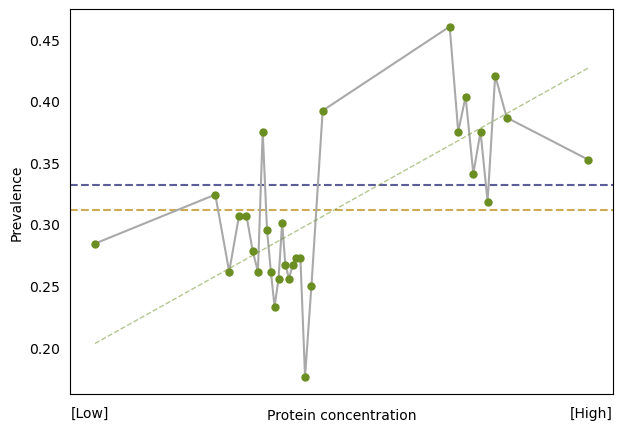

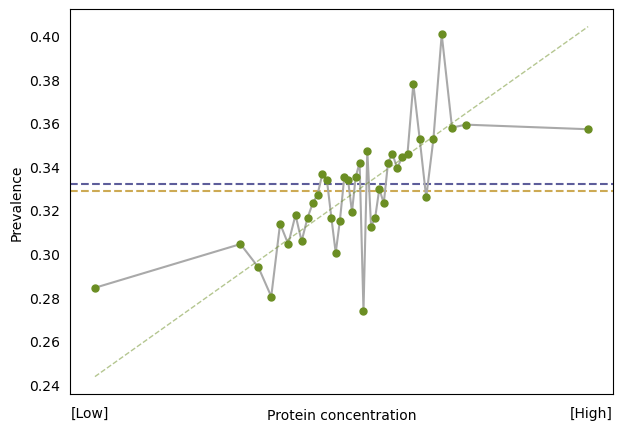

In [11]:
fig1 = PCA_anal(hyp_prot, incl_hyp_dftot, 'I10 Essential (primary) hypertension', 'in_cluster', windows=30, regression_range=(1, -1))
fig2 = PCA_anal(hyp_prot, incl_hyp_dftot, 'I10 Essential (primary) hypertension', 'all_population', windows=40, regression_range=(1, -1))
fig1.savefig('Fig4_A.png', dpi=1000, bbox_inches='tight')
fig2.savefig('Fig4_B.png', dpi=1000, bbox_inches='tight')

## Figure4 C,D

In [63]:
# Common proteins in celiac clusters
c1 = df[(df['file']=='comp')&(df['cluster']=='cl2')]
c2 = df[(df['file']=='comp')&(df['cluster']=='cl3')]
c3 = df[(df['file']=='3k')&(df['cluster']=='cl6')]
c4= df[(df['file']=='leiden')&(df['cluster']=='cl7')]
celi_prot = list(set(c1['protein']).intersection(c2['protein']).intersection(c3['protein']).intersection(c4['protein']))

In [65]:
# Participants in celiac clusters
ince1 = comp[comp['cl2']==1]
ince2 = comp[comp['cl3']==1]
ince3 = k3[k3['cl6']==1]
ince4 = leiden[leiden['cl7']==1] 
incl_celi = ince1[['eid']].merge(ince2[['eid']], how='outer').merge(ince3[['eid']], how='outer').merge(ince4[['eid']], how='outer')
incl_celi_dftot = incl_celi.merge(dftot,on='eid',how='left')

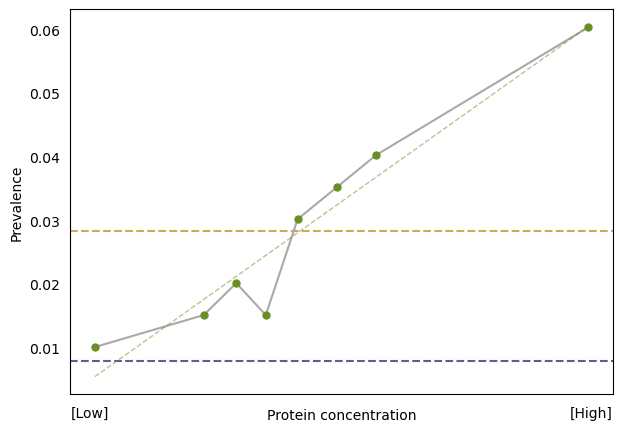

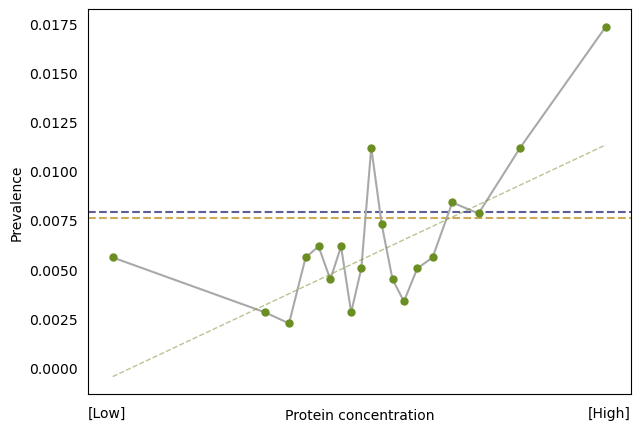

In [69]:
fig1 = PCA_anal(celi_prot, incl_celi_dftot, 'K90 Intestinal malabsorption', 'in_cluster',  windows=8)
fig2 = PCA_anal(celi_prot, incl_celi_dftot, 'K90 Intestinal malabsorption', 'all_population', windows=20, slice_num=1,regression_range=(1, -1))
fig1.savefig('Fig4_C.png', dpi=1000, bbox_inches='tight')
fig2.savefig('Fig4_D.png', dpi=1000, bbox_inches='tight')